# Lab 3 - GAN

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import time

### Networks

In [2]:
class Discrimator(nn.Module):
    def __init__(self):
        super(Discrimator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 4, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(5184, 1),
        )

    def forward(self, x):
        return self.net(x)

In [3]:
disc = Discrimator().to("cuda")

input = torch.rand(5, 3, 64, 64).to("cuda")  # B, C, H, W

disc(input).shape

torch.Size([5, 1])

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear_transforamtion = nn.Linear(64, 1024)

        self.conv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 3, 5, stride=1, padding=2),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.linear_transforamtion(x)
        x = torch.reshape(x, [-1, 64, 4, 4])
        return self.conv(x)

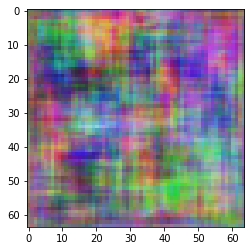

In [5]:
gen = Generator().to("cuda")

input = torch.randn(5, 64).to("cuda")  # randd - standard normal distribution - N(0, 1)

output = (gen(input) + 1) / 2
plt.imshow(output[0].permute(1, 2, 0).detach().cpu().numpy())

Random as expected. Input and weights are random so we get averaged output and average color is gray!

### Dataset

In [6]:
transform = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), lambda x: x * 2 - 1]
)  # scales to [-1, 1]

dataset = torchvision.datasets.ImageFolder("./crawled_cakes", transform=transform)

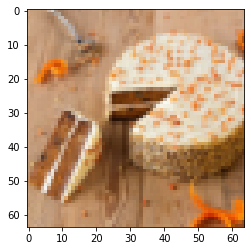

In [7]:
img, label = dataset[0]
img = (img + 1) / 2
img.shape
plt.imshow(img.permute(1, 2, 0))

### Mockup training
Warmup, simply to learn non-standard training loop in pytorch

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
        )

    def forward(self, x):
        return self.net(x)


simple_net = SimpleNet()
simple_net(torch.rand(5, 10))

tensor([[0.1197],
        [0.0737],
        [0.0821],
        [0.0828],
        [0.0792]], grad_fn=<AddmmBackward0>)

In [9]:
[name for name, _ in simple_net.named_parameters()]

['net.0.weight',
 'net.0.bias',
 'net.2.weight',
 'net.2.bias',
 'net.4.weight',
 'net.4.bias']

In [10]:
EPOCH = 1000
BATCH_SIZE = 8

simple_net = SimpleNet().to("cuda")
optimizer = optim.Adam(simple_net.net[2].parameters(), lr=0.001)
input_data = torch.rand(BATCH_SIZE, 10).to("cuda")
target = torch.full((BATCH_SIZE, 1), fill_value=42).to("cuda")

for _ in range(EPOCH):
    output = simple_net(input_data)

    optimizer.zero_grad()

    loss = torch.abs(torch.subtract(output, target)).mean()
    loss.backward()

    optimizer.step()

In [11]:
simple_net(input_data)

tensor([[23.8694],
        [26.6986],
        [29.7946],
        [26.4972],
        [24.8924],
        [23.6465],
        [24.2582],
        [27.3996]], device='cuda:0', grad_fn=<AddmmBackward0>)

We got what we wanted. Output is converging towards 42s! And we only changed second layer of the network.

### GAN Training

In [12]:
EPOCH = 4000
BATCH_SIZE = 64
LR = 0.00005
BETAS = (0.5, 0.999)

D = Discrimator().to("cuda")
G = Generator().to("cuda")
optimizerD = optim.Adam(D.parameters(), lr=LR, betas=BETAS)
optimizerG = optim.Adam(G.parameters(), lr=LR, betas=BETAS)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)
criterion = nn.MSELoss().to("cuda")

In [14]:
target_epoch = 0
# load from checkpoints
target_epoch = 4000
data = torch.load(f"lab3_checkpoints/D_{target_epoch}")
D.load_state_dict(data)
data = torch.load(f"lab3_checkpoints/G_{target_epoch}")
G.load_state_dict(data)
data = torch.load(f"lab3_checkpoints/optimizer_{target_epoch}")
optimizerD.load_state_dict(data["optimizerD"])
optimizerG.load_state_dict(data["optimizerG"])

In [15]:
start_time = time.time()

for epoch in range(target_epoch + 1, EPOCH + 1):
    lossD, lossG = 1, 1
    for gt_images, _ in train_dataloader:
        input = torch.randn((BATCH_SIZE, 64), device="cuda")
        fake_images = G(input)

        # Training Generator
        optimizerG.zero_grad()

        true_targets = torch.ones((BATCH_SIZE, 1)).to("cuda")

        output = D(fake_images)
        lossG = criterion(output, true_targets)
        lossG.backward()

        optimizerG.step()

        # Training Discriminator
        optimizerD.zero_grad()
        gt_images, gt_labels = gt_images.to("cuda"), torch.ones(
            (BATCH_SIZE, 1), device="cuda"
        )
        fake_labels = torch.zeros((BATCH_SIZE, 1), device="cuda")

        output_gt = D(gt_images)
        output_fake = D(fake_images.detach())

        lossD = 0.5 * (
            criterion(output_gt, gt_labels) + criterion(output_fake, fake_labels)
        )

        if lossD > 0.1:
            lossD.backward()
            optimizerD.step()

    print(
        f"epoch: {epoch:04d}, time: {(time.time() - start_time)/60:1f}min, lossD: {lossD:.4f}, lossG: {lossG:.4f}"
    )
    if epoch % 20 == 0:
        print("Saving!")
        torch.save(D.state_dict(), f"lab3_checkpoints/D_{epoch}")
        torch.save(G.state_dict(), f"lab3_checkpoints/G_{epoch}")
        torch.save(
            {
                "epoch": epoch,
                "lossD": lossD,
                "lossG": lossG,
                "optimizerG": optimizerG.state_dict(),
                "optimizerD": optimizerD.state_dict(),
            },
            f"lab3_checkpoints/optimizer_{epoch}",
        )

First 3000 epochs: batch_size=64, LR=0.0001

Then 1000 epochs: batch_size=64, LR=0.00002

### Results

In [16]:
test_inputs = torch.randn((8, 64)).to("cuda")


def test_model(epoch: int):
    G_test = Generator().to("cuda")
    data = torch.load(f"lab3_checkpoints/G_{epoch}")
    G_test.load_state_dict(data)

    with torch.no_grad():
        output = (
            ((G_test(test_inputs) + 1) / 2).permute(0, 2, 3, 1).detach().cpu().numpy()
        )

        fig, axs = plt.subplots(1, 8)
        fig.set_size_inches(30, 10)
        for idx, img in enumerate(output):
            axs[idx % 8].imshow(img)

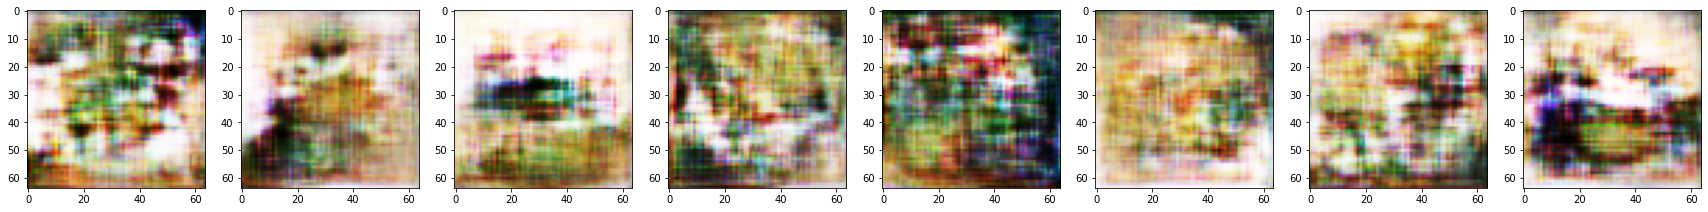

In [17]:
test_model(100)

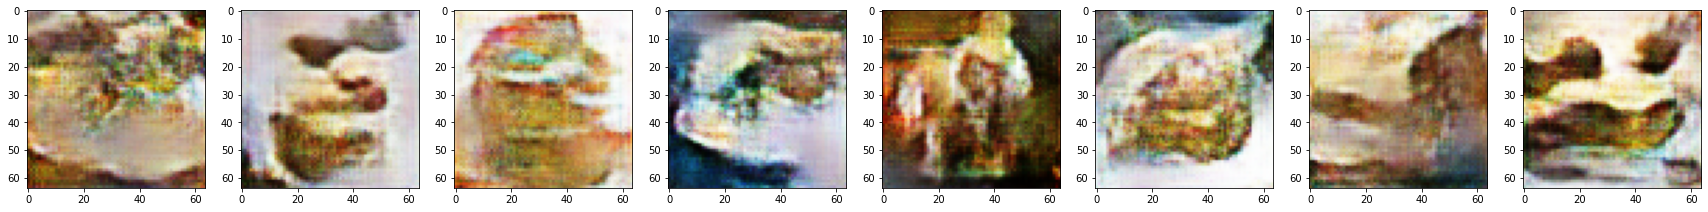

In [18]:
test_model(500)

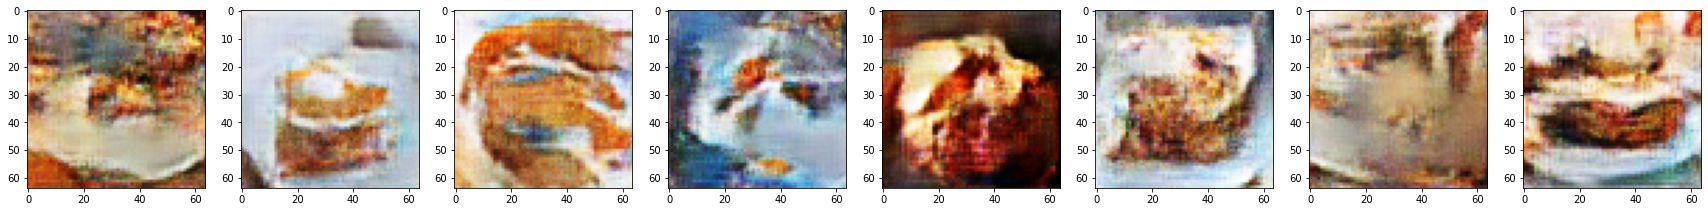

In [19]:
test_model(1000)

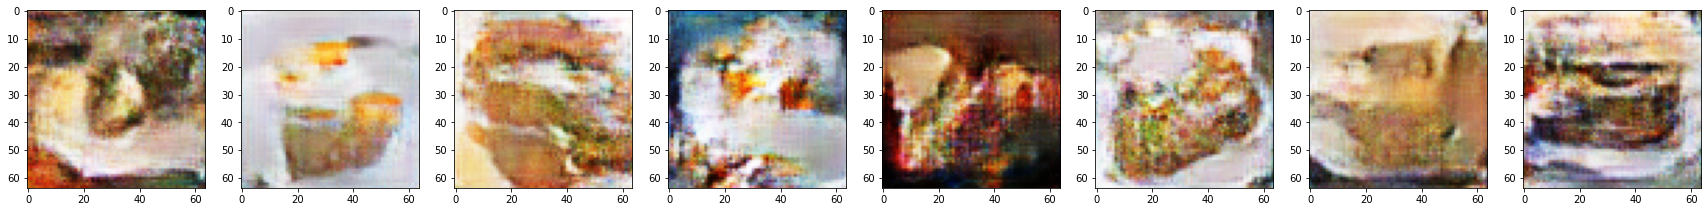

In [20]:
test_model(2000)

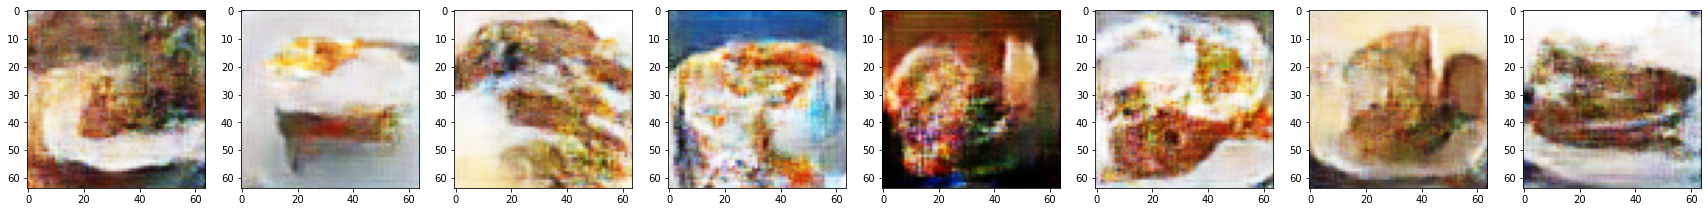

In [21]:
test_model(2980)

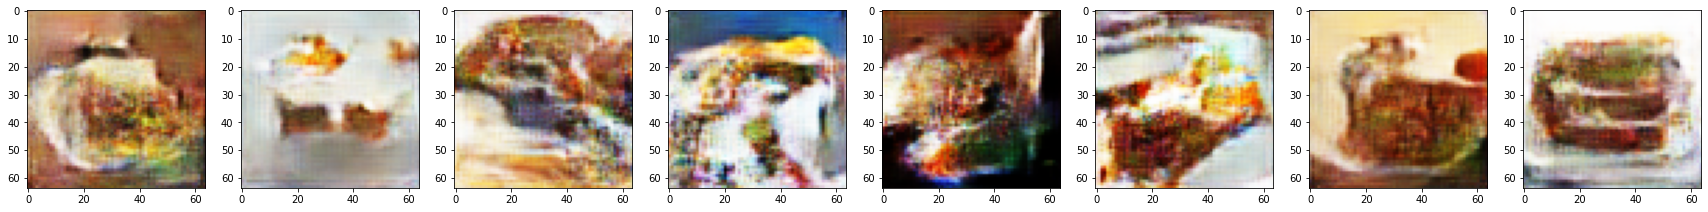

In [22]:
test_model(4000)

I'd say we got pretty good results. 

### Recreating image

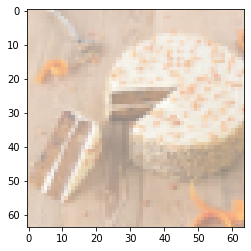

In [23]:
img_gt, label = dataset[1]
img_gt = (img + 1) / 2
img_gt = img_gt.permute(1, 2, 0).cpu()
img_gt.shape
plt.imshow(img_gt)

In [26]:
G_test = Generator().to("cuda")
data = torch.load("lab3_checkpoints/G_4000")
G_test.load_state_dict(data)

input_learnable = torch.randn((1, 64), device="cuda", requires_grad=True)
img = dataset[1][0].to("cuda")

for p in G_test.parameters():
    p.requires_grad = False

optimizer = optim.SGD([input_learnable], lr=0.01, momentum=0.9)
criterion = nn.MSELoss().to("cuda")

In [27]:
outputs = []
for _ in range(1000):
    optimizer.zero_grad()

    output = G_test(input_learnable)
    loss = criterion(output, img.unsqueeze(0))
    loss.backward()
    optimizer.step()

    # save frame
    outputs.append(
        ((output.squeeze(0) + 1) / 2).permute(1, 2, 0).detach().cpu().numpy()
    )

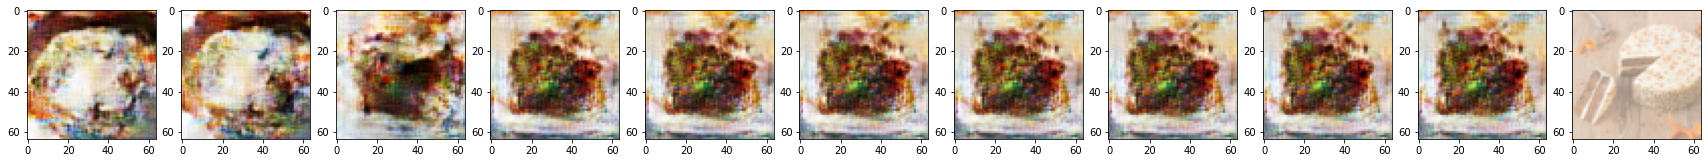

In [28]:
import matplotlib.animation as animation

fig, axs = plt.subplots(1, 11)
fig.set_size_inches(30, 20)
# each frame
ims = []
for idx, output in enumerate(outputs):
    if idx % (len(outputs) // 10) == 0:
        axs[idx // (len(outputs) // 10)].imshow(output)

axs[10].imshow(img_gt)

We can see that we got closer in direction of target image pretty fast, but couldn't get any closer with more epochs.

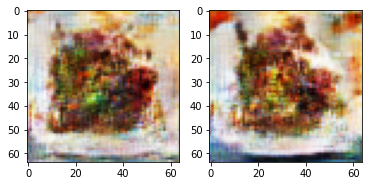

In [29]:
input_learnable_copy = torch.clone(input_learnable).detach()
input_learnable_copy[0][21:37] = 0
output = G_test(input_learnable_copy)
output = (output.squeeze(0).permute(1, 2, 0).cpu() + 1) / 2

fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[999])
axs[1].imshow(output)

### Recreating non-cake image

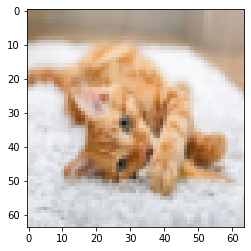

In [30]:
img = torchvision.io.read_image("cat.jpg")
img = transforms.Resize((64, 64), antialias=True)(img)
img = img / 128 - 1
img_gt = torch.clone(img)
img_gt = (img + 1) / 2
img_gt = img_gt.permute(1, 2, 0).cpu()
img_gt.shape
plt.imshow(img_gt)

In [33]:
G_test = Generator().to("cuda")
data = torch.load("lab3_checkpoints/G_4000")
G_test.load_state_dict(data)

input_learnable = torch.randn((1, 64), device="cuda", requires_grad=True)
img = dataset[1][0].to("cuda")

for p in G_test.parameters():
    p.requires_grad = False

optimizer = optim.SGD([input_learnable], lr=0.01, momentum=0.9)
criterion = nn.MSELoss().to("cuda")

In [34]:
outputs = []
for _ in range(1000):
    optimizer.zero_grad()

    output = G_test(input_learnable)
    loss = criterion(output, img.unsqueeze(0))
    loss.backward()
    optimizer.step()

    # save frame
    outputs.append(
        ((output.squeeze(0) + 1) / 2).permute(1, 2, 0).detach().cpu().numpy()
    )

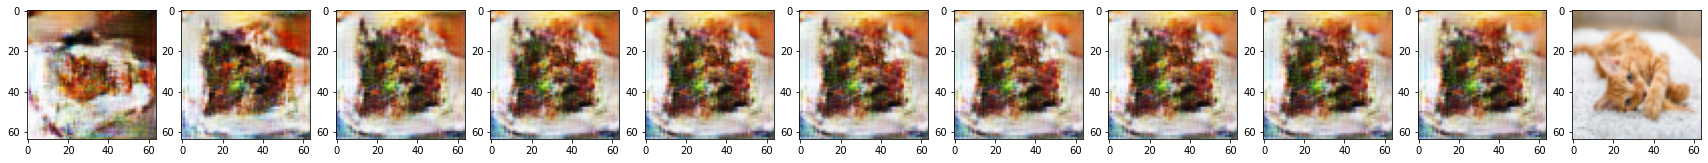

In [36]:
fig, axs = plt.subplots(1, 11)
fig.set_size_inches(30, 20)
# each frame
ims = []
for idx, output in enumerate(outputs):
    if idx % (len(outputs) // 10) == 0:
        axs[idx // (len(outputs) // 10)].imshow(output)

axs[10].imshow(img_gt)

If we take image outside of domain the model was trained on, we can observe much worse results. Model can only paint cakes. It may try to paint cake similar to cat, but it doesn't work well

### Intermediate images

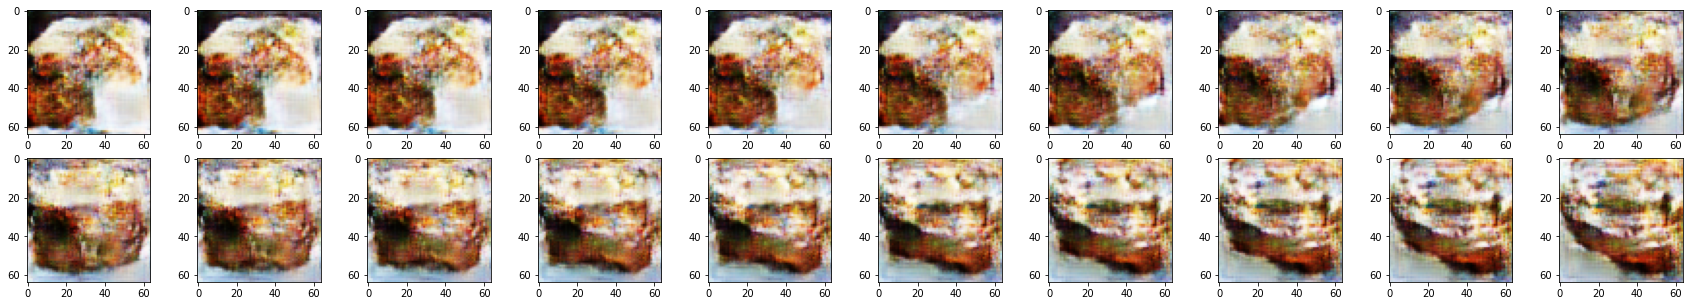

In [35]:
input1 = torch.randn((1, 64), device="cuda")
input2 = torch.randn((1, 64), device="cuda")

inputs = []

for weight in torch.arange(0, 1.01, 0.051, device="cuda"):
    inputs.append(torch.lerp(input1, input2, weight))


fig, axs = plt.subplots(2, 10)
fig.set_size_inches(30, 5)
# each frame
ims = []
for idx, input in enumerate(inputs):
    img = G_test(input)
    img = ((img.squeeze(0) + 1) / 2).permute(1, 2, 0).detach().cpu().numpy()
    axs[idx // 10, idx % 10].imshow(img)


We can see nice and smooth progression between two images.

### Summary

Very cool exercise! Challenging, but so satisfying when the results appeared! The hardest part was definitely training GANs, I've decieded to use Upsamping + Convolutions (and 64x64 size) from the start. I've also added Batchnorms to Generator. I've observed than bigger batch_size resulted in more stable training process. With BS=16 GANs quickly went into mode collapse and image quality decreased. Only with BS=16 I was able to train it.

I trained for 3000 epochs with BS=64, LR=0.0001 (10x higher than recommended in lab instructions, but it worked I guess) and then decreased LR to 0.00002 (5x time smaller) and trained for 1000 epochs. When I tried to decrease BS as well I recieved terrible results. Results deteriorated in just 40 epochs and GAN fell into mode collapse. So I sticked to BS=64 and finetuned model to it's final version.